Support algs imported!


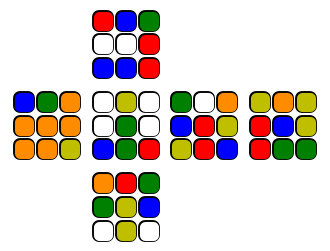

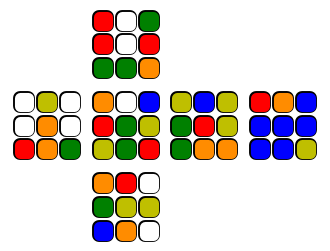

Cube initiated


In [1]:
%run "2gen optimal solver.ipynb"

In [2]:
cube = Cube()
# cube.apply_moves("R U' R U' R U' R U' R U' R U' R U' R U' R U' R U' R U'")
# solver_2gen(cube)

cube1 = Cube(1)
cube1

# [12,5,10,41,1,43,28,39,19,37] (edges top + FR)
# [37,39,41,43,0,1,2,9,10,11,18,19,20,27,28,29,5,8,12,15,47] # (FR + FRD + top layer - top corners)

         36 37 38
         39 40 41
         42 43 44
27 28 29  0 1 2  9 10 11  18 19 20
30 31 32  3 4 5  12 13 14  21 22 23
33 34 35  6 7 8  15 16 17  24 25 26
         45 46 47
         48 49 50
         51 52 53

In [3]:
def ids_solved(cubestate, ids):
    solved_state = np.array([1]*9+[2]*9+[3]*9+[4]*9+[5]*9+[6]*9)
    for i in ids:
        if cubestate[i] != solved_state[i]:
            return False
    return True

cube = Cube()

ids = [0,42,2,44,18,38,20,36,8,47, 50,14,21]

ids_solved(cube.state,ids)

def get_edge_state(cube, ids = [12,5,10,41,1,43,28,39,19,37]):
    string = ""
    for i in ids:
        string += str(cube.state[i])
    return string

get_edge_state(cube)

'2125154535'

In [4]:
'''
Gen algs for swapping edges in top + RF
How?
Table lookup from solved


'''
# @njit
def get_cube_state(cubestate):
    state = ""
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18,19,20,21,23,24,25,26,27,28,39,30,32,33,34,35,37,39,41,43,46,48]: # enough IDs to make each cube unique
        state += str(cubestate[i])
    return state

def gray_cube(ids):
    cube = Cube()
    for i in ids:
        cube.state[i] = 0
    return cube

def gen_subalgs(N): # , moveset?
    subalgs = []
    for n in range(1,N+1):
        ai = alg_index_2gen(n) # change depending on moveset
        start_alg = ai.get_alg()
        subalgs.append(start_alg)
        ai.increment()
        while ai.get_alg() != start_alg:
            subalgs.append(ai.get_alg())
            ai.increment()
    return subalgs

def gen_table(subalgs, ids_grayed, save_table = False):
    table = {}
    for alg in subalgs:
        cube = gray_cube(ids_grayed)
        cube.apply_moves(alg)
        state = get_cube_state(cube.state)
        if state in table:
            table[state].append(inverse_alg(alg))
        else:
            table[state] = [inverse_alg(alg)]
    return table


def gen_algs(N,ids_grayed):
    '''
    N = length of algs in table lookup/brute force
    ids_grayed = ids to be grayed out (sets which pieces/stickers can be moved in our algs)
    
    returns a dictionary of each state we solve using this 
    '''
    t = time.time()
    
    subalgs = gen_subalgs(N)
    print(f"Subalgs generated ({round(time.time()-t,4)}s)")
    
    table = gen_table(subalgs, ids_grayed)
    print(f"Lookup table generated ({round(time.time()-t,4)}s)")
    
    algs = []
    algs_dict = {}
    for premove_alg in subalgs:
        cube = gray_cube(ids_grayed)
        cube.apply_moves(premove_alg)
        state = get_cube_state(cube.state)
        if state in table:
            for lookup_alg in table[state]:
                if premove_alg.split(" ")[-1][0] != lookup_alg.split(" ")[0][0]:
                    alg = premove_alg + " " + lookup_alg
                    algs.append(alg)
                    
                    # check if alg solves something we already have an alg for
                    new = True
                    for u in ["","U","U2","U'"]:
                        cube = Cube()
                        cube.apply_moves(inverse_alg(alg))
                        final_state = get_cube_state(cube.state)
                    if final_state in algs_dict:
                        if alg not in algs_dict[final_state]:
                            algs_dict[final_state].append(alg)
                    else:
                        algs_dict[final_state] = [alg]
    print(f"Algs generated ({round(time.time()-t,4)}s)")

    return algs_dict, algs
    
    
N = 8
ids_grayed = [12,5,10,41,1,43,28,39,19,37]

genned_algs, algs = gen_algs(N,ids_grayed)
print(len(genned_algs))

# NOTE! This produce many duplicates due to pre-aufs. Should be 15 (?), not 60

Subalgs generated (0.0836s)
Lookup table generated (0.7239s)
Algs generated (1.354s)
60


In [6]:
tot = 0
startU = 0

for i,k in enumerate(genned_algs.keys()):
    print(f"{i+1}: {genned_algs[k][0]}")
    tot += len(genned_algs[k][0].split(" "))
    startU += genned_algs[k][0][0]=="U"
print(tot/60)
print(startU)

1: R' U' R' U' R' U R U R U
2: R' U' R' U' R U R U R U'
3: R' U' R' U' R2 U R U R U2
4: U R' U' R' U' R' U R U R
5: U' R' U' R' U' R U R U R
6: U2 R' U' R' U' R2 U R U R
7: R U R U R U R' U' R' U' R2
8: R' U R U' R' U' R' U' R U R2
9: R' U R U R' U' R' U' R' U R2
10: R2 U R U R' U' R' U' R' U R'
11: R2 U R U R U' R' U' R' U' R'
12: R2 U R U R2 U' R' U' R' U2 R'
13: R U' R U R U R U' R' U' R2
14: R2 U' R U R U R U' R' U' R
15: R U2 R U R U R2 U' R' U' R2
16: R' U2 R U2 R2 U2 R2 U2 R U2 R
17: R2 U2 R U2 R2 U2 R2 U2 R U2 R2
18: R' U R' U' R' U' R' U R U R2
19: R2 U' R' U' R U R U R U' R
20: R2 U' R' U R U R U R' U' R
21: R U2 R' U R U R' U2 R U' R' U'
22: R U' R' U' R U2 R' U R U R' U2
23: R U R' U2 R U' R' U' R U2 R' U
24: R2 U2 R2 U2 R2 U2 R2 U2 R2 U2 R2 U2
25: U R U R' U2 R U' R' U' R U2 R'
26: U2 R U' R' U' R U2 R' U R U R'
27: U' R U2 R' U R U R' U2 R U' R'
28: R2 U2 R' U R U R U2 R U' R' U' R
29: R2 U' R' U' R U2 R U R U R' U2 R
30: R' U R U R' U2 R' U' R' U' R U2 R2
31: R' U2 R U' 

In [ ]:
ai = alg_index_2gen(3)

ai.increment()
ai.get_alg()

       5 5 5
       5 5 5
       5 5 5
4 4 4  1 1 1  2 2 2  3 3 3
4 4 4  1 1 1  2 2 2  3 3 3
4 4 4  1 1 1  2 2 2  3 3 3
       6 6 6
       6 6 6
       6 6 6

In [ ]:
edges = {
    1: [21,14],
    2: [50,16],
    3: [5, 12],
    4: [41,10],
    5: [43,1 ],
    6: [39,28],
    7: [37,19]
}

def swap_edges(cube, e1, e2):
    cube.state[e1[0]], cube.state[e1[1]], cube.state[e2[0]], cube.state[e2[1]] = cube.state[e2[0]], cube.state[e2[1]], cube.state[e1[0]], cube.state[e1[1]]
    
